### Import lib

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import pickle
import warnings
import nltk 
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, precision_score,recall_score, accuracy_score, make_scorer, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score,train_test_split, cross_validate, cross_val_predict
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from pandarallel import pandarallel
from os import walk
from wordcloud import WordCloud, STOPWORDS
from time import time
from scipy.stats import wilcoxon
import os
import sys
import random
from sklearn.exceptions import ConvergenceWarning
from pandas.errors import SettingWithCopyWarning

# Initialization
pandarallel.initialize(progress_bar=True)

# disable unuseful warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore", category=ConvergenceWarning)
    warnings.simplefilter("ignore", category=FutureWarning)
    warnings.simplefilter("ignore", category=SettingWithCopyWarning)
os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::RuntimeWarning')


INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


## Import Data

In [2]:
# Read the urls database
urls_df = pd.read_csv(r'phishing_site_urls.csv')

# Rename the column
urls_df.rename(columns = {'URL':'Content'}, inplace = True)

# Change label "bad" in 0 and "good" in 1
urls_df.loc[urls_df["Label"]=="bad", "Label"]= 0
urls_df.loc[urls_df["Label"]=="good", "Label"]= 1
urls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  549346 non-null  object
 1   Label    549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [3]:
urls_df.drop_duplicates(inplace=True)
urls_df.isnull().sum()

Content    0
Label      0
dtype: int64

In [4]:
# URL labels overview
label_counter = pd.DataFrame(urls_df.Label.value_counts())
print(label_counter.Label)
fig = px.bar(label_counter, x=label_counter.index, y=label_counter.Label)
fig.update_layout(
    xaxis_title="Label",
    yaxis_title="Instances",
)
fig.show()

1    392897
0    114299
Name: Label, dtype: int64


In [5]:
# Read the emails dataset
pathwalk = walk(r"enron-spam/")

allHamData, allSpamData = [], []
for root, dr, file in pathwalk:
    if 'ham' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allHamData.append(" ".join(ip.readlines()))

    elif 'spam' in str(file):
        for obj in file:
            with open(root + '/' + obj, encoding='latin1') as ip:
                allSpamData.append(" ".join(ip.readlines()))
                
# remove all redundant data
allHamData = list(set(allHamData))
allSpamData = list(set(allSpamData))

# merge it in a dataframe
hamPlusSpamData = allHamData + allSpamData

# Labels: "bad" = 0 and "good" = 1
labels = [1]*len(allHamData) + [0]*len(allSpamData)

emails_df = pd.DataFrame({"Content": hamPlusSpamData, "Label": labels})

In [6]:
# Email labels overview
label_counter = pd.DataFrame(emails_df.Label.value_counts())
print(label_counter.Label)
fig = px.bar(label_counter, x=label_counter.index, y=label_counter.Label)
fig.update_layout(
    xaxis_title="Label",
    yaxis_title="Instances",
)
fig.show()

1    15910
0    14584
Name: Label, dtype: int64


In [7]:
df = pd.concat([urls_df, emails_df], axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537690 entries, 0 to 30493
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  537690 non-null  object
 1   Label    537690 non-null  object
dtypes: object(2)
memory usage: 12.3+ MB


In [8]:
label_counter = pd.DataFrame(df.Label.value_counts())
print(label_counter.Label)
fig = px.bar(label_counter, x=label_counter.index, y=label_counter.Label)
fig.update_layout(
    xaxis_title="Label",
    yaxis_title="Instances",
)
fig.show()

1    408807
0    128883
Name: Label, dtype: int64


## Pipeline

In [9]:
stopwords = nltk.corpus.stopwords.words('english')
snow_stemmer = SnowballStemmer('english')

In [10]:
analyzer = CountVectorizer(stop_words = stopwords).build_analyzer()

In [11]:
def print_metrics(results):
    metrics = ['accuracy','precision_ham', 'recall_ham','precision_spam', 'recall_spam']
    for metric in metrics:
        print(f'{metric:15}', np.round(results["test_"+metric].mean(),3), [np.round(elem,3) for elem in results["test_"+metric]])
    print()
    print(f'{"vocabulary size":15}', np.mean([len(results['estimator'][i][0].vocabulary_) for i in range(n_folds)]))
    print(f'{"fit_time":15}', np.round(results["fit_time"].mean()))
    print(f'{"score_time":15}', np.round(results["score_time"].mean()))

In [12]:
# KFold cross_validate
n_folds = 10
# instead of Kfold()
kf = StratifiedKFold(n_folds)

y = df.Label
y=y.astype('int')
y

0        0
1        0
2        0
3        0
4        0
        ..
30489    0
30490    0
30491    0
30492    0
30493    0
Name: Label, Length: 537690, dtype: int32

In [20]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced

# Split in training and test set but with stratify (balance split)
X_train, X_test, y_train, y_test = train_test_split(df.Content.values, y,
                                                    stratify=y, 
                                                    test_size=0.25, random_state = 42)


## Multinomial Naive Bayes

In [60]:
from sklearn.naive_bayes import MultinomialNB
pipe = Pipeline([('vect', CountVectorizer(stop_words = stopwords)), ('samp', RandomUnderSampler()), 
        ('clf', MultinomialNB(alpha=0.05, fit_prior=True, class_prior=[0.25, 0.75]))])
model = make_pipeline_imb(pipe)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [61]:
SVCrbf_count = cross_validate(pipe,
                         df.Content.values,
                         y,
                         scoring = {'precision_ham': make_scorer(precision_score,pos_label = 1),                         
                                    'precision_spam': make_scorer(precision_score,pos_label = 0),
                                    'recall_ham': make_scorer(recall_score,pos_label = 1),
                                    'recall_spam': make_scorer(recall_score,pos_label = 0),
                                    'accuracy': make_scorer(accuracy_score),
                                    'fscore_spam': make_scorer(f1_score,pos_label = 0),
                                    'fscore_ham': make_scorer(f1_score,pos_label = 1)},                    
                         return_estimator = True,
                         cv = kf,
                         n_jobs = 12) # Number of jobs to run in parallel. 
                                      # Training the estimator and computing the score are parallelized over the cross-validation splits.

print_metrics(SVCrbf_count)

accuracy        0.89 [0.772, 0.953, 0.963, 0.955, 0.942, 0.944, 0.907, 0.841, 0.872, 0.748]
precision_ham   0.946 [0.957, 0.977, 0.972, 0.968, 0.955, 0.961, 0.916, 0.88, 0.881, 0.99]
recall_ham      0.91 [0.733, 0.961, 0.979, 0.973, 0.969, 0.967, 0.968, 0.915, 0.962, 0.676]
precision_spam  0.792 [0.514, 0.884, 0.933, 0.914, 0.897, 0.892, 0.874, 0.693, 0.831, 0.488]
recall_spam     0.825 [0.897, 0.927, 0.912, 0.899, 0.855, 0.874, 0.717, 0.606, 0.586, 0.978]

vocabulary size 590623.3
fit_time        14.0
score_time      1.0



CLASSIFICATION REPORT

                   pre       rec       spe        f1       geo       iba       sup

        Bad       0.92      0.91      0.98      0.92      0.94      0.88     32221
       Good       0.97      0.98      0.91      0.97      0.94      0.90    102202

avg / total       0.96      0.96      0.93      0.96      0.94      0.89    134423


CONFUSION MATRIX


<AxesSubplot: >

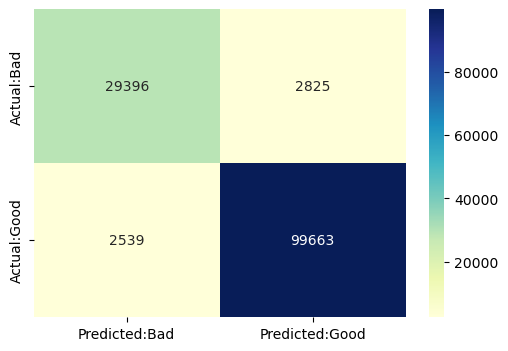

In [62]:
con_mat = pd.DataFrame(confusion_matrix(y_test, y_pred),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report_imbalanced(y_test, y_pred,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")

In [25]:
# save results in pkl objects
pickle.dump(model,open('phishing_SVC_model.pkl','wb'))
pickle.dump(SVCrbf_count,open('phishing_SVC_CV.pkl','wb'))
pickle.dump(y_pred,open('phishing_SVC_pred.pkl','wb'))
pickle.dump(y_test,open('phishing_SVC_test.pkl','wb'))
'''loaded_model = pickle.load(open('phishing_RF.pkl', 'rb'))
result = loaded_model.score(X_test,y_test)
print(result)'''

"loaded_model = pickle.load(open('phishing_RF.pkl', 'rb'))\nresult = loaded_model.score(X_test,y_test)\nprint(result)"

In [ ]:
pickle.dump(y_test,open('phishing_SVC_test.pkl','wb'))

In [ ]:
loaded_model = pickle.load(open('phishing_SVC_pred.pkl', 'rb'))
loaded_test = pickle.load(open('phishing_SVC_test.pkl', 'rb'))
con_mat = pd.DataFrame(confusion_matrix(loaded_test, loaded_model),
            columns = ['Predicted:Bad', 'Predicted:Good'],
            index = ['Actual:Bad', 'Actual:Good'])

print('\nCLASSIFICATION REPORT\n')
print(classification_report_imbalanced(loaded_test, loaded_model,
                            target_names =['Bad','Good']))

print('\nCONFUSION MATRIX')
plt.figure(figsize= (6,4))
sns.heatmap(con_mat, annot = True,fmt='d',cmap="YlGnBu")